In [1]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import cv2

Total number of images: 988
Image shape: (128, 118, 3)
Dtype before conversion: uint8
Dtype after conversion: float32


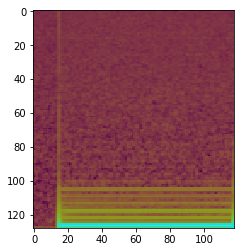

In [2]:
images_train = [cv2.imread(file) for file in glob.glob("D:/Jupyter/Azure/Capstone Project/train_c/*.png")]
plt.imshow(images_train[2])
print("Total number of images: " + str(len(images_train)))
print("Image shape: " + str(images_train[1].shape))

print("Dtype before conversion: " + str(images_train[1].dtype))
images_train1 = np.asarray(images_train, dtype=np.float32)
print("Dtype after conversion: " + str(images_train1[1].dtype))

In [3]:
images_train_c = images_train1/255.

In [4]:
images_train_c = np.concatenate((images_train_c, images_train_c), axis = 0)
images_train_x = np.concatenate((images_train_c, images_train_c), axis = 0)
images_train_x.shape

(3952, 128, 118, 3)

In [5]:
images_train2 = tf.constant(images_train1)

Total number of images: 659
Image shape: (128, 118, 3)
Dtype before conversion: uint8
Dtype after conversion: float32


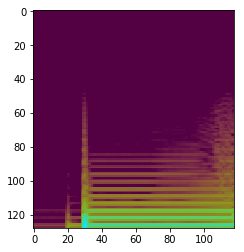

In [6]:
images_test = [cv2.imread(file) for file in glob.glob("D:/Jupyter/Azure/Capstone Project/test_c/*.png")]
plt.imshow(images_test[2])
print("Total number of images: " + str(len(images_test)))
print("Image shape: " + str(images_test[1].shape))

print("Dtype before conversion: " + str(images_test[1].dtype))
images_test = np.asarray(images_test, dtype=np.float32)
print("Dtype after conversion: " + str(images_test[1].dtype))

In [10]:
import pandas as pd
label = pd.read_csv('train_labels.csv')
print(label.head())
print(label.count())

label = label['appliance']
label_y = label.astype(np.float32)

     id  appliance
0  1000          8
1  1001          1
2  1002          8
3  1003         10
4  1004          6
id           988
appliance    988
dtype: int64


In [11]:
label_y = np.concatenate((label_y, label_y), axis = 0)
label_y = np.concatenate((label_y, label_y), axis = 0)
label_y.shape

(3952,)

In [12]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
le = LabelEncoder()
ohe = OneHotEncoder()
le.fit(label_y)
le_label = le.transform(label_y)
ohe_y = ohe.fit(le_label.reshape(-1,1))
y_label = ohe_y.transform(le_label.reshape(-1,1)).toarray()
y_label.shape

(3952, 11)

In [13]:
y_label.dtype

dtype('float64')

In [14]:
y_label1 = tf.constant(y_label)

In [15]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

In [16]:
def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

In [17]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

In [18]:
def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

In [19]:
def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

In [20]:
def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [21]:
learning_rate = 0.001
training_epochs = 50
batch_size = 64
n_hidden_1 = 400
n_hidden_2 = 400
n_input = 45312 
n_classes = 11
n_samples = 988

In [22]:
x = tf.placeholder("float", [None, 128, 118, 3])
y = tf.placeholder("float", [None, n_classes])

In [23]:
print(x)
print(y)

Tensor("Placeholder:0", shape=(?, 128, 118, 3), dtype=float32)
Tensor("Placeholder_1:0", shape=(?, 11), dtype=float32)


In [24]:
#x_image = tf.reshape(x,[-1,28,28,1])
x_image = tf.reshape(x, [-1,128,118,3])
x_image.shape

TensorShape([Dimension(None), Dimension(128), Dimension(118), Dimension(3)])

In [25]:
convo_1 = convolutional_layer(x,shape=[6,6,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [26]:
convo_1.shape

TensorShape([Dimension(None), Dimension(128), Dimension(118), Dimension(32)])

In [27]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[6,6,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [28]:
convo_2.shape

TensorShape([Dimension(None), Dimension(64), Dimension(59), Dimension(64)])

In [29]:
convo_2_flat = tf.reshape(convo_2_pooling,[-1,32*30*64])
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat,1024))

In [30]:
full_layer_one.shape

TensorShape([Dimension(None), Dimension(1024)])

In [31]:
hold_prob = tf.placeholder(tf.float32)
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [32]:
full_one_dropout.shape

TensorShape([Dimension(None), Dimension(1024)])

In [33]:
y_pred = normal_full_layer(full_one_dropout,11)

In [34]:
y_pred.shape

TensorShape([Dimension(None), Dimension(11)])

In [35]:
#cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_label,logits=y_pred))
#optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)
#train = optimizer.minimize(cross_entropy)

cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = y, logits = y_pred))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

In [36]:
init = tf.global_variables_initializer()

In [37]:
'''
steps = 100

with tf.Session() as sess:
    
    sess.run(init)
    idxs = np.random.permutation(988) 
    X_random = images_train1[idxs]
    Y_random = y_label[idxs]
    
    for i in range(steps):
        batch_x = X_random[i * batch_size:(i+1) * batch_size]
        batch_y = Y_random[i * batch_size:(i+1) * batch_size]
        
        sess.run(train,feed_dict={x:batch_x, y:batch_y,hold_prob:0.5})
        
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_label,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))
            
        print("Epoch: {} cost={:.4f}".format(i, acc))
    print("Model has completed {} Epochs of Training".format(steps))
            #print(sess.run(acc,feed_dict={x:mnist.test.images,y_true:mnist.test.labels,hold_prob:1.0}))
            #print('\n')
'''

'\nsteps = 100\n\nwith tf.Session() as sess:\n    \n    sess.run(init)\n    idxs = np.random.permutation(988) \n    X_random = images_train1[idxs]\n    Y_random = y_label[idxs]\n    \n    for i in range(steps):\n        batch_x = X_random[i * batch_size:(i+1) * batch_size]\n        batch_y = Y_random[i * batch_size:(i+1) * batch_size]\n        \n        sess.run(train,feed_dict={x:batch_x, y:batch_y,hold_prob:0.5})\n        \n        if i%100 == 0:\n            \n            print(\'Currently on step {}\'.format(i))\n            print(\'Accuracy is:\')\n            # Test the Train Model\n            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_label,1))\n\n            acc = tf.reduce_mean(tf.cast(matches,tf.float32))\n            \n        print("Epoch: {} cost={:.4f}".format(i, acc))\n    print("Model has completed {} Epochs of Training".format(steps))\n            #print(sess.run(acc,feed_dict={x:mnist.test.images,y_true:mnist.test.labels,hold_prob:1.0}))\n            #print(\

In [38]:
idxs = np.random.permutation(n_samples) 
X_random = images_train1[idxs]
Y_random = y_label[idxs]
i =3
batch_x = X_random[i * batch_size:(i+1) * batch_size]
batch_y = Y_random[i * batch_size:(i+1) * batch_size]
batch_x.shape

(64, 128, 118, 3)

In [39]:
def next_batch(num, data, labels):
    idx = np.arange(0 , len(data))
    np.random.shuffle(idx)
    idx = idx[:num]
    data_shuffle = [data[ i] for i in idx]
    labels_shuffle = [labels[ i] for i in idx]

    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [ ]:
sess = tf.InteractiveSession()
sess.run(init)

for epoch in range(training_epochs):
    avg_cost = 0.0
    total_batch = int(n_samples/batch_size)
    #idxs = np.random.permutation(n_samples) 
    #X_random = images_train1[idxs]
    #Y_random = y_label[idxs]
    
    for i in range(total_batch): 
        batch_x, batch_y = next_batch(batch_size, images_train1, y_label)
        #batch_x = X_random[i * batch_size:(i+1) * batch_size]
        #batch_y = Y_random[i * batch_size:(i+1) * batch_size]
        #_, c = sess.run(train,feed_dict={x:batch_x, y:batch_y,hold_prob:0.5})
        _, c = sess.run([optimizer, cost], feed_dict={x: batch_x, y: batch_y, hold_prob: 0.5})

        avg_cost += c/total_batch
    print("Epoch: {} cost={:.4f}".format(epoch,avg_cost))
print("Model has completed {} Epochs of Training".format(training_epochs))

In [ ]:
# Test model
correct_predictions = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_label, 1))
print(correct_predictions[0])

In [ ]:
correct_predictions = tf.cast(correct_predictions, "float")
print(correct_predictions[0])

In [ ]:
accuracy = tf.reduce_mean(correct_predictions)
type(accuracy)

In [ ]:
print("Accuracy:", sess.run(accuracy.eval({x: images_train1, y: y_label, hold_prob:1})))

In [ ]:
pred_test = y_pred.eval(feed_dict = {x:images_test, hold_prob:1})
prediction=tf.argmax(pred_test,1)
print ("predictions", prediction.eval(feed_dict={x: images_test, hold_prob:1}, session=sess))

In [ ]:
label_test = pd.read_csv('submission_format.csv')

In [ ]:
submission = pd.DataFrame()
submission['id']= label_test['id']
submission['appliance']= sess.run(prediction)
submission.to_csv('submission7.csv', index=False)
submission.shape

In [ ]:
submission.head()